In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *
from src.real_data import Metrics, Vectors 
from src.abstain import *

import sklearn
from sklearn.metrics import roc_curve, auc, jaccard_score
import pandas as pd
from supervenn import supervenn

from scipy.stats import bernoulli, spearmanr

from operator import xor

import ast

import os



In [2]:

def compute_group_stats(val, group_train, group_test, instance_err_true_train, instance_err_true_test, instance_err_pred_train, instance_err_pred_test):
    """
    Computes false positive rate (FPR), false negative rate (FNR), and regret rate for a given group value.

    Parameters:
    - val: The group value to compute statistics for.
    - group_train: Group labels for the training set.
    - group_test: Group labels for the test set.
    - instance_err_true_train: True instance errors for the training set.
    - instance_err_true_test: True instance errors for the test set.
    - instance_err_pred_train: Predicted instance errors for the training set.
    - instance_err_pred_test: Predicted instance errors for the test set.

    Returns:
    - Dictionary containing FPR, FNR, and regret rates for the specified group.
    """
    group_train = np.asarray(group_train)
    group_test = np.asarray(group_test)
    instance_err_true_train = np.asarray(instance_err_true_train)
    instance_err_true_test = np.asarray(instance_err_true_test)
    instance_err_pred_train = np.asarray(instance_err_pred_train)
    instance_err_pred_test = np.asarray(instance_err_pred_test)
    
    def calculate_rates(group, instance_err_true, instance_err_pred):
        group_indices = np.where(group == val)[0]
        instance_err_true_group = instance_err_true[group_indices]
        instance_err_pred_group = instance_err_pred[group_indices]
        
        false_positives = np.sum((instance_err_pred_group == 1) & (instance_err_true_group == 0))
        false_negatives = np.sum((instance_err_pred_group == 0) & (instance_err_true_group == 1))
        
        total_in_group = len(group_indices)
        
        fpr = false_positives / total_in_group if total_in_group > 0 else 0.0
        fnr = false_negatives / total_in_group if total_in_group > 0 else 0.0
        
        return fpr, fnr
    
    def calculate_regret_rate(group, instance_err_true, instance_err_pred):
        regret = abs(instance_err_true - instance_err_pred)
        group_indices = np.where(group == val)[0]
        regret_in_group = np.sum(regret[group_indices])
        total_in_group = len(group_indices)
        return regret_in_group / total_in_group if total_in_group > 0 else 0.0
    
    def calculate_risk_rate(group, instance_err_true):
        group_indices = np.where(group == val)[0]
        risk_in_group = np.sum(instance_err_true[group_indices])
        total_in_group = len(group_indices)
        return risk_in_group / total_in_group if total_in_group > 0 else 0.0
    
    # Calculate rates for training and test sets
    fpr_train, fnr_train = calculate_rates(group_train, instance_err_true_train, instance_err_pred_train)
    fpr_test, fnr_test = calculate_rates(group_test, instance_err_true_test, instance_err_pred_test)
    
    # Calculate regret rates
    regret_train = calculate_regret_rate(group_train, instance_err_true_train, instance_err_pred_train)
    regret_test = calculate_regret_rate(group_test, instance_err_true_test, instance_err_pred_test)
    
    risk_train = calculate_risk_rate(group_train, instance_err_true_train)
    risk_test = calculate_risk_rate(group_test, instance_err_true_test)
    
    return {
        'fpr_train': fpr_train,
        'fnr_train': fnr_train,
        'fpr_test': fpr_test,
        'fnr_test': fnr_test,
        'regret_train': regret_train,
        'regret_test': regret_test,
        'risk_train': risk_train,
        'risk_test': risk_test
    }

class MetricsCalculator:
    def __init__(self, vectors):
        """
        Initializes the MetricsCalculator with vectors and a Metrics object.

        Parameters:
        - vectors: A data structure to fetch vectors related to the metrics.
        """
        self.vectors = vectors
        self.metrics = Metrics()

    def calculate_metrics(self, draw_id):
        """
        Calculate and add various metrics to the Metrics object for a given draw_id.

        Parameters:
        - draw_id: The ID of the current draw for which metrics are calculated.
        """
        instance_err_true_train = self.vectors.get_vector("metadata", draw_id, "instance_err_true_train") #True 01 Error Train
        instance_err_true_test = self.vectors.get_vector("metadata", draw_id, "instance_err_true_test") #True 01 Error Test
        
        dataset = self.vectors.get_vector("metadata", draw_id, "dataset")
        noise_type = self.vectors.get_vector("metadata", draw_id, "noise_type")
        model_type = self.vectors.get_vector("metadata", draw_id, "model_type")
        T = self.vectors.get_vector("metadata", draw_id, "T")
        yn_train = self.vectors.get_vector("metadata", draw_id, "yn_train")
        train_preds = self.vectors.get_vector("metadata", draw_id, "train_preds")
        test_preds = self.vectors.get_vector("metadata", draw_id, "test_preds")
        train_probs = self.vectors.get_vector("metadata", draw_id, "train_probs")
        test_probs = self.vectors.get_vector("metadata", draw_id, "test_probs")
        y_train = self.vectors.get_vector("metadata", draw_id, "y_train")
        y_test = self.vectors.get_vector("metadata", draw_id, "y_test")
        ambiguity_train = self.vectors.get_vector("metadata", draw_id, "train_ambiguity")/100
        
        self.metrics.add_metric("metadata", draw_id, "ambiguity_train_vector", ambiguity_train)

        #print(self.vectors.get_all_vectors("metadata", draw_id))
        
        X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = "age")

        n_models = 100
        max_iter = 1000
        p_y_x_dict =  calculate_prior(y_train, 
                                      noise_type = noise_type, 
                                      group=group_train) #Clean prior
        
        posterior = calculate_posterior(yn_train, T, p_y_x_dict[0])
        
        susceptibility_vector_posterior = (posterior > 0).astype(int)
        
        noise_rates = np.where(y_train == 0, T[0, 1], T[1, 0])
        susceptibility_vector_noise =  (noise_rates > 0).astype(int)
        
        self.metrics.add_metric("metadata", draw_id, "susceptibility_vector_posterior", susceptibility_vector_posterior)
        self.metrics.add_metric("metadata", draw_id, "susceptible_posterior", np.sum(susceptibility_vector_posterior)/len(susceptibility_vector_posterior))
        
        self.metrics.add_metric("metadata", draw_id, "susceptibility_vector_noise", susceptibility_vector_noise)
        self.metrics.add_metric("metadata", draw_id, "susceptible_noise", np.sum(susceptibility_vector_noise)/len(susceptibility_vector_noise))
        
        
        epsilon = 0.1
        misspecify_flag = "correct"


        plausible_instance_err_anticipated_train = (ambiguity_train > 0).astype(int)

        
        self.metrics.add_metric("metadata", draw_id, "median_ambiguity", np.median(ambiguity_train))
        self.metrics.add_metric("metadata", draw_id, "mean_ambiguity", np.mean(ambiguity_train))
        
        unresponsive_vector_posterior = ((susceptibility_vector_posterior == 1) & (ambiguity_train == 0))
        unresponsive_vector_noise = ((susceptibility_vector_noise == 1) & (ambiguity_train == 0))
        
        self.metrics.add_metric("metadata", draw_id, "unresponsive_vector_posterior", unresponsive_vector_posterior)
        self.metrics.add_metric("metadata", draw_id, "unresponsive_vector_noise", unresponsive_vector_noise)
        
        self.metrics.add_metric("metadata", draw_id, "unresponsive_posterior", np.sum(unresponsive_vector_posterior)/len(unresponsive_vector_posterior))
        self.metrics.add_metric("metadata", draw_id, "unresponsive_noise", np.sum(unresponsive_vector_noise)/len(unresponsive_vector_noise))
        
        for err_method in ["01", "forward", "backward"]:
            if err_method == "01":
                pop_err_anticipated_train, instance_err_anticipated_train = instance_01loss(yn_train, train_preds)
                pop_err_anticipated_test, instance_err_anticipated_test = instance_01loss(y_test, test_preds)
                
            elif err_method == "forward":
                pop_err_anticipated_train, instance_err_anticipated_train = instance_forward_01loss(yn_train, train_probs, T)
                pop_err_anticipated_test, instance_err_anticipated_test = instance_forward_01loss(y_test, test_probs, T)
                
            elif err_method == "backward":
                _, _, pop_err_anticipated_train, instance_err_anticipated_train = natarajan_unbiased_01_loss(yn_train, train_preds, T)
                _, _, pop_err_anticipated_test, instance_err_anticipated_test = natarajan_unbiased_01_loss(y_test, test_preds, T)
                
                
            empirical_regret_train, regret_instances_train = instance_01loss(instance_err_anticipated_train, instance_err_true_train)

            self.metrics.add_metric(err_method, draw_id, "regret_vector", regret_instances_train)
            self.metrics.add_metric(err_method, draw_id, "clean_risk_test", np.mean(instance_err_true_test)) #average clean 01loss
            self.metrics.add_metric(err_method, draw_id, "noisy_risk_train", np.mean(instance_err_anticipated_train)) #average clean 01loss
            self.metrics.add_metric(err_method, draw_id, "clean_risk_train", np.mean(instance_err_true_train)) #average clean 01loss
            
            self.metrics.add_metric(err_method, draw_id, "delta_pop_err_train", abs(np.mean(instance_err_anticipated_train) - np.mean(instance_err_true_train))) #average clean 01loss
            
            self.metrics.add_metric(err_method, draw_id, "actual_regret_train", empirical_regret_train)
            
            #How well ambiguity flags regretful instances
            self.metrics.add_metric("metadata", draw_id, "coverage_regret_train", np.mean(abs(plausible_instance_err_anticipated_train- regret_instances_train)))
            
            #print(plausible_instance_err_anticipated_train, regret_instances_train)
            plausible_instance_err_anticipated_train = (plausible_instance_err_anticipated_train > 0).astype(int)
            regret_instances_train = (regret_instances_train > 0).astype(int)
            jaccard = jaccard_score(plausible_instance_err_anticipated_train,regret_instances_train)
            self.metrics.add_metric("metadata", draw_id, "jaccard_train", jaccard)
            
            fp_indices_train = ((instance_err_anticipated_train == 1) & (instance_err_true_train == 0))
            fn_indices_train = ((instance_err_anticipated_train == 0) & (instance_err_true_train == 1))
            
            self.metrics.add_metric(err_method, draw_id, "fp_vector", fp_indices_train.astype(int))
            self.metrics.add_metric(err_method, draw_id, "fn_vector", fn_indices_train.astype(int))
            
            indices_regret = np.logical_or(fp_indices_train, fn_indices_train)
            
            #self.metrics.add_metric(err_method, draw_id, "actual_regret_fpr_train",  fp_indices_train.sum()/len(indices_regret) if len(indices_regret) != 0 else 0)
            #self.metrics.add_metric(err_method, draw_id, "actual_regret_fnr_train", fn_indices_train.sum()/len(indices_regret) if len(indices_regret) != 0 else 0)
            
            # Get the indices where instance_err_anticipated_train == 0
            indices_condition = (instance_err_anticipated_train == 0)

            # Calculate the conditional probability P(instance_err_true_train == 1 | instance_err_anticipated_train == 0)
            conditional_prob = fn_indices_train.sum() / indices_condition.sum() if indices_condition.sum() != 0 else 0

            # Add the metric
            self.metrics.add_metric(err_method, draw_id, "actual_regret_fnr_train", conditional_prob)
            
            # Get the indices where instance_err_anticipated_train == 0
            indices_condition = (instance_err_anticipated_train == 1)

            # Calculate the conditional probability P(instance_err_true_train == 1 | instance_err_anticipated_train == 0)
            conditional_prob = fp_indices_train.sum() / indices_condition.sum() if indices_condition.sum() != 0 else 0

            # Add the metric
            self.metrics.add_metric(err_method, draw_id, "actual_regret_fpr_train", conditional_prob)


            non_regret_instances_train = 1-regret_instances_train
        

            regret_indices_train = np.where(regret_instances_train == 1)[0]


            #self.metrics.add_metric(err_method, draw_id, "regret_instances_train", regret_instances_train)
            #self.metrics.add_metric(err_method, draw_id, "ambiguity_train", ambiguity_train)
            #self.metrics.add_metric(err_method, draw_id, "probs_train", train_probs)
            
            groups = ["age", "hiv"] if  (dataset == "saps" or dataset == "saps_imbalanced") else ["age", "sex"]
                    
            for group in groups:
                
                # Load the dataset splits and group labels
                _, _, _, _, group_train, group_test = load_dataset_splits(dataset, group)
                
                for val in np.unique(group_train):
                    group_stats = compute_group_stats(val, group_train, group_test, instance_err_true_train, instance_err_true_test, instance_err_anticipated_train, instance_err_anticipated_test)
                    self.metrics.add_metric(err_method, draw_id, f"fpr_{group}_{val}", group_stats["fpr_train"])

                    self.metrics.add_metric(err_method, draw_id, f"fnr_{group}_{val}", group_stats["fnr_train"])

                    self.metrics.add_metric(err_method, draw_id, f"regret_{group}_{val}", group_stats["regret_train"])
                    self.metrics.add_metric(err_method, draw_id, f"risk_{group}_{val}", group_stats["risk_test"])
            for c in [0,1]:
                
                class_stats = compute_group_stats(c, y_train, y_test, instance_err_true_train, instance_err_true_test, instance_err_anticipated_train, instance_err_anticipated_test)
                self.metrics.add_metric(err_method, draw_id, f"fpr_class_{c}", class_stats["fpr_train"])

                self.metrics.add_metric(err_method, draw_id, f"fnr_class_{c}", class_stats["fnr_train"])
  
                self.metrics.add_metric(err_method, draw_id, f"regret_class_{c}", class_stats["regret_train"])
                self.metrics.add_metric(err_method, draw_id, f"risk_class_{c}", class_stats["risk_test"])
         
    def get_metrics(self):
        """
        Returns the calculated metrics.

        Returns:
        - Metrics object containing all calculated metrics.
        """
        return self.metrics

    def visualize_binary_arrays(self, true_array, anticipated_array, err_method, draw_id):
        """
        Visualize the comparison between true and anticipated error arrays.

        Parameters:
        - true_array: Array of true errors.
        - anticipated_array: Array of anticipated errors.
        - err_method: Error method used.
        - draw_id: ID of the current draw.
        """
        df = pd.DataFrame({
            'True Error': true_array,
            'Anticipated Error': anticipated_array
        })

        plt.figure(figsize=(10, 2))
        sns.heatmap(df.T, cmap="viridis", cbar=False)
        plt.axhline(y=1, color='gray', linestyle='--') 
        plt.title(f'Comparison of True and Anticipated Errors\nMethod: {err_method}, Draw ID: {draw_id}')
        plt.xlabel('Index')
        plt.ylabel('Error Type')
        plt.show()

In [3]:
def load_vectors(dataset, model_type, noise_type, noise_level, training_loss, epsilon=0.1, misspecify="correct", fixed_class = None, fixed_noise = None):
    """
    Load the vectors data from the specified path.

    Parameters:
    - parent_dir (str): The parent directory path.
    - dataset (str): The dataset name.
    - model_type (str): The model type.
    - noise_type (str): The noise type.
    - misspecify (str): The misspecify parameter.
    - noise_level (str): The noise level.
    - epsilon (str): The epsilon value.

    Returns:
    - vectors: The loaded vectors data.
    """
    parent_dir = "/scratch/hdd001/home/snagaraj/"
    files_path = os.path.join(parent_dir, "results", "regret", dataset, model_type, noise_type, misspecify)
    
    if noise_type == "class_independent":
        path = os.path.join(files_path, f"{training_loss}_{noise_level}_{epsilon}_vectors.pkl")
    elif noise_type == "class_conditional":
        path = os.path.join(files_path, f"{training_loss}_{noise_level}_{fixed_class}_{fixed_noise}_{epsilon}_vectors.pkl")

    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file at path {path} does not exist.")
    
    # Load the vectors data from the file
    with open(path, 'rb') as file:
        vectors = pkl.load(file)
    
    return vectors


In [4]:
dataset = "cshock_eicu"
noise_type = "class_independent"
model_type = "LR"
n_models = 10
n_draws = 1
max_iter = 10000

T = np.array([[1.0, 0.0],
              [0.2, 0.8]])

all_metrics_test = []

for training_loss in ["None"]:
    vectors = run_experiment(dataset, noise_type, model_type, n_models=n_models, max_iter=max_iter, training_loss=training_loss, T=T, n_draws = n_draws)
    
    metrics_calculator = MetricsCalculator(vectors)
    
    for draw_id in range(n_draws):
        metrics_calculator.calculate_metrics(draw_id)
        
    metrics = metrics_calculator.get_metrics()
    
    #

    for method in ["metadata", "01", "forward", "backward"]:
        for draw_id in range(n_draws):
             #Get all metric names dynamically
            all_metric_names = metrics.get_all_metrics(method, draw_id)
            for metric_name in all_metric_names:
                value = metrics.get_metric(method, draw_id, metric_name)
                if value is not None:
                    all_metrics_test.append({
                        "training_loss": training_loss,
                        "err_method": method,
                        "draw_id": draw_id,
                        "metric_name": metric_name,
                        "value": value
                    })



  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
# Create a DataFrame from the collected metrics
metrics_df_test = pd.DataFrame(all_metrics_test)

print(sorted(metrics_df_test.metric_name.unique()))

['actual_regret_fnr_train', 'actual_regret_fpr_train', 'actual_regret_train', 'ambiguity_train_vector', 'clean_risk_test', 'clean_risk_train', 'coverage_regret_train', 'delta_pop_err_train', 'fn_vector', 'fnr_age_0', 'fnr_age_1', 'fnr_class_0', 'fnr_class_1', 'fnr_sex_0', 'fnr_sex_1', 'fp_vector', 'fpr_age_0', 'fpr_age_1', 'fpr_class_0', 'fpr_class_1', 'fpr_sex_0', 'fpr_sex_1', 'jaccard_train', 'mean_ambiguity', 'median_ambiguity', 'noisy_risk_train', 'regret_age_0', 'regret_age_1', 'regret_class_0', 'regret_class_1', 'regret_sex_0', 'regret_sex_1', 'regret_vector', 'risk_age_0', 'risk_age_1', 'risk_class_0', 'risk_class_1', 'risk_sex_0', 'risk_sex_1', 'susceptibility_vector_noise', 'susceptibility_vector_posterior', 'susceptible_noise', 'susceptible_posterior', 'unresponsive_noise', 'unresponsive_posterior', 'unresponsive_vector_noise', 'unresponsive_vector_posterior']


In [6]:
metrics_df_test[metrics_df_test["metric_name"]=="actual_regret_fnr_train"]

,training_loss,err_method,draw_id,metric_name,value
21,None,01,0,actual_regret_fnr_train,0.059121
55,None,forward,0,actual_regret_fnr_train,0.113217
89,None,backward,0,actual_regret_fnr_train,0.059121


# Load Data

In [14]:
fixed_class = 0
fixed_noise = 0.0

all_metrics = []

for dataset in tqdm(["cshock_eicu", "cshock_mimic",  "saps", "support", "lungcancer"]):
    for model_type in ["LR", "NN"]:
        for noise_type in ["class_conditional"]:
            for noise_level in [0.05, 0.2, 0.4]:
                for training_loss in ["None", "backward", "forward"]:
                    
                    if training_loss == "None":
                        method_lis = ["metadata", "01"]
                    else:
                        method_lis =  ["metadata"] +[training_loss]
                        
                        
                    try:
                        vectors = load_vectors(dataset, model_type, noise_type, noise_level=noise_level, training_loss = training_loss, fixed_noise=fixed_noise, fixed_class= fixed_class)
                    except Exception as e:
                        print(e)
                        continue

                    metrics_calculator = MetricsCalculator(vectors)
    
                    n_draws = len(metrics_calculator.vectors.vectors['metadata'])
                    metrics = metrics_calculator.get_metrics()

                    for draw_id in range(10):
                        metrics_calculator.calculate_metrics(draw_id)

                    
                        groups = ["age", "hiv"] if  (dataset == "saps" or dataset == "saps_imbalanced") else ["age", "sex"]
                    
                        for method in method_lis:
                            
                             #Get all metric names dynamically
                            all_metric_names = sorted(metrics.get_all_metrics(method, draw_id))
                            for metric_name in all_metric_names:

                                value = metrics.get_metric(method, draw_id, metric_name)

                                #if "vector"  in metric_name:
                                #print(value)
                                all_metrics.append({
                                    "dataset": dataset,
                                    "model_type": model_type,
                                    "noise_type": noise_type,
                                    "noise_level": noise_level,
                                    "training_loss": training_loss,
                                    "err_method": method, #ignore err_method column for now
                                    "draw_id": draw_id,
                                    "metric_name": metric_name,
                                    "value": value if metric_name != "jaccard_train" else value
                                })
#                                 

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv('all_results_forward.csv', index=False)
metrics_df

,dataset,model_type,noise_type,noise_level,training_loss,err_method,draw_id,metric_name,value
0,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,ambiguity_train_vector,"[0.025, 1.0, 0.195, 0.0, 0.755, 0.0, 0.0, 0.15..."
1,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,coverage_regret_train,0.644718
2,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,jaccard_train,0.043991
3,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,mean_ambiguity,0.260009
4,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,median_ambiguity,0.045
...,...,...,...,...,...,...,...,...,...
43015,lungcancer,NN,class_conditional,0.40,forward,forward,9,risk_age_1,0.268167
43016,lungcancer,NN,class_conditional,0.40,forward,forward,9,risk_class_0,0.281169
43017,lungcancer,NN,class_conditional,0.40,forward,forward,9,risk_class_1,0.355131
43018,lungcancer,NN,class_conditional,0.40,forward,forward,9,risk_sex_0,0.307088


In [9]:
#metrics_df = pd.read_csv('all_results.csv')
metrics_df['training_loss'] = metrics_df['training_loss'].fillna("None")
metrics_df

,dataset,model_type,noise_type,noise_level,training_loss,err_method,draw_id,metric_name,value
0,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,ambiguity_train_vector,"[0.025, 1.0, 0.195, 0.0, 0.755, 0.0, 0.0, 0.15..."
1,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,coverage_regret_train,0.644718
2,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,jaccard_train,0.043991
3,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,mean_ambiguity,0.260009
4,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,median_ambiguity,0.045
...,...,...,...,...,...,...,...,...,...
28675,lungcancer,NN,class_conditional,0.40,backward,backward,9,risk_age_1,0.266615
28676,lungcancer,NN,class_conditional,0.40,backward,backward,9,risk_class_0,0.348837
28677,lungcancer,NN,class_conditional,0.40,backward,backward,9,risk_class_1,0.263298
28678,lungcancer,NN,class_conditional,0.40,backward,backward,9,risk_sex_0,0.301341


In [13]:
metrics_df[(metrics_df["metric_name"]=="median_ambiguity") 
           & (metrics_df["dataset"]=="cshock_eicu")
           & (metrics_df["noise_level"]==0.4)
           & (metrics_df["training_loss"]=="backward")]

,dataset,model_type,noise_type,noise_level,training_loss,err_method,draw_id,metric_name,value
2354,cshock_eicu,LR,class_conditional,0.4,backward,metadata,0,median_ambiguity,0.325
2401,cshock_eicu,LR,class_conditional,0.4,backward,metadata,1,median_ambiguity,0.33
2448,cshock_eicu,LR,class_conditional,0.4,backward,metadata,2,median_ambiguity,0.325
2495,cshock_eicu,LR,class_conditional,0.4,backward,metadata,3,median_ambiguity,0.325
2542,cshock_eicu,LR,class_conditional,0.4,backward,metadata,4,median_ambiguity,0.335
2589,cshock_eicu,LR,class_conditional,0.4,backward,metadata,5,median_ambiguity,0.33
2636,cshock_eicu,LR,class_conditional,0.4,backward,metadata,6,median_ambiguity,0.325
2683,cshock_eicu,LR,class_conditional,0.4,backward,metadata,7,median_ambiguity,0.325
2730,cshock_eicu,LR,class_conditional,0.4,backward,metadata,8,median_ambiguity,0.32
2777,cshock_eicu,LR,class_conditional,0.4,backward,metadata,9,median_ambiguity,0.325


Plotting for dataset: cshock_eicu


/tmp/ipykernel_21459/314068823.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].apply(convert_to_float)


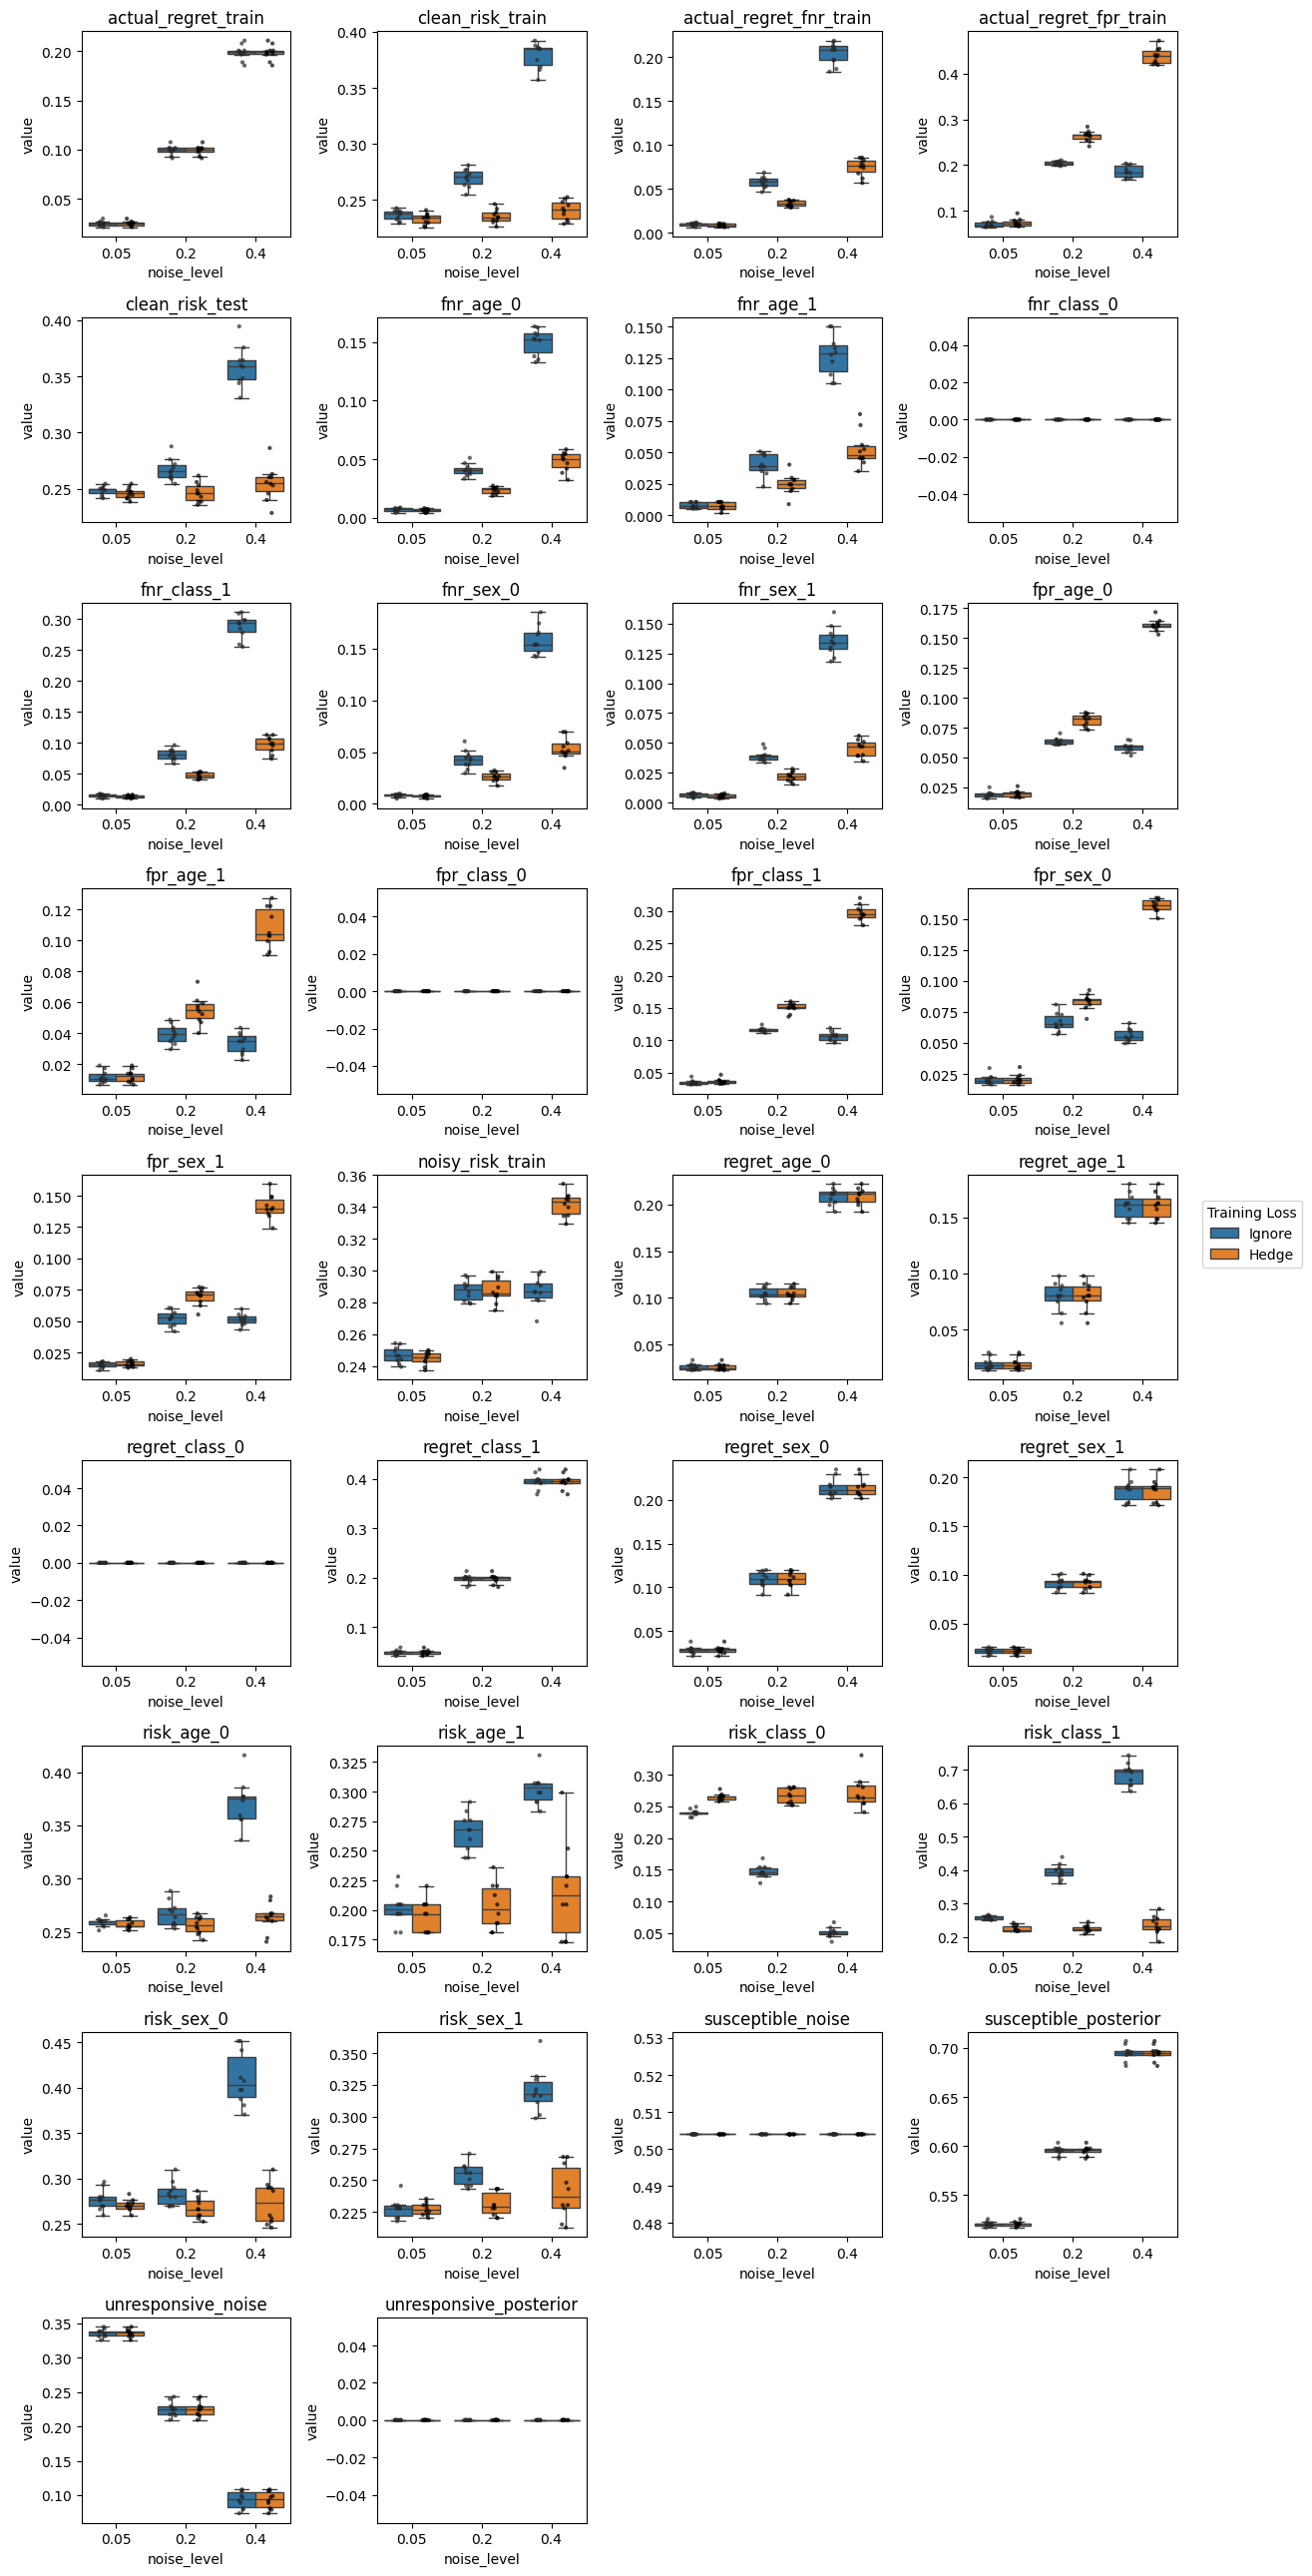

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

# Function to convert values to float
def convert_to_float(value):
    try:
        if isinstance(value, (int, float)):
            return float(value)
        evaluated_value = ast.literal_eval(value)
        if isinstance(evaluated_value, (list, np.ndarray)):
            return float(evaluated_value[0])
        return float(evaluated_value)
    except (ValueError, SyntaxError, TypeError):
        return np.nan

# Function to create boxplots
def create_boxplot(df, metric_names, title, ncols=4):
    # Convert the 'value' column to float
    df['value'] = df['value'].apply(convert_to_float)

    # Ensure DataFrame is not empty
    if df.empty:
        print("No data available for plotting.")
        return
    
    actual_metric_names = [metric_name for metric_name in metric_names if metric_name in sub_df.metric_name.unique()]
    

    # Set up the number of rows/columns in the plot grid
    nrows = (len(actual_metric_names) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), sharey=False)
    axs = axs.flatten()  # Flatten axes for easier indexing
    
    
    
    for i, metric_name in enumerate(actual_metric_names):
        # Filter data for the current metric
        metric_data = df[df['metric_name'] == metric_name]

        # Ensure there's data for the current metric
        if metric_data.empty:
            continue

        # Plot boxplot
        sns.boxplot(
            ax=axs[i],
            x='noise_level',
            y='value',
            hue='training_loss',
            data=metric_data,
            showfliers=False
        )

        # Overlay stripplot for better visualization of individual points
        sns.stripplot(
            ax=axs[i],
            x='noise_level',
            y='value',
            hue='training_loss',
            data=metric_data,
            dodge=True,
            marker='o',
            s=3,
            alpha=0.7,
            palette='dark:black',
            legend=False  # Avoid multiple legends
        )

        axs[i].set_title(metric_name)
        axs[i].legend().remove()

    # Handle the first plot's legend separately (outside the subplots)
    handles, labels = axs[0].get_legend_handles_labels()
    
    loss_map = {"backward": "Hedge", "None":"Ignore"}
    labels = [loss_map[label] if label in loss_map else label for label in labels]
    fig.legend(handles, labels, title='Training Loss', bbox_to_anchor=(1.05, 0.5), loc='center')

    # Remove unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.savefig(f'/h/snagaraj/noise_multiplicity/figures/appendices_{title}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

# Sample usage
model_type = "LR"
noise_type = "class_conditional"

for dataset in [
    "cshock_eicu",
    "cshock_mimic",
    "support",
    "saps",
    "lungcancer"][:1]:
    sub_df = metrics_df[
        (metrics_df["model_type"] == model_type) & 
        (metrics_df["noise_type"] == noise_type) & 
        (metrics_df["dataset"] == dataset)
    ]

    metric_names = sorted(sub_df['metric_name'].unique())
    metric_names = [name for name in metric_names if '_vector' not in name]
    
    metric_names = ['actual_regret_fnr_train', 
                    'actual_regret_fpr_train', 
                    'actual_regret_train', 
                    'clean_risk_test', 
                    'clean_risk_train', 
                    #'coverage_regret_train', 
                    #'delta_pop_err_train', 
                    'fnr_age_0', 
                    'fnr_age_1', 
                    'fnr_class_0', 
                    'fnr_class_1',
                    'fnr_sex_0', 
                    'fnr_sex_1', 
                    #'fp_vector', 
                    'fpr_age_0', 
                    'fpr_age_1', 
                    'fpr_class_0', 
                    'fpr_class_1',
                    'fpr_sex_0', 
                    'fpr_sex_1', 
                    #'mean_ambiguity', 
                    #'median_ambiguity',
                    'noisy_risk_train', 
                    'regret_age_0', 
                    'regret_age_1', 
                    'regret_class_0', 
                    'regret_class_1', 
                    'regret_sex_0',
                    'regret_sex_1', 
                    #'regret_vector', 
                    'risk_age_0', 
                    'risk_age_1', 
                    'risk_class_0', 
                    'risk_class_1', 
                    'risk_sex_0', 
                    'risk_sex_1',
                    'susceptible_posterior',
                   'susceptible_noise',
                   'unresponsive_posterior',
                   'unresponsive_noise']
    
    priority_metrics = ["actual_regret_train", "clean_risk_train"]
    metric_names = priority_metrics + sorted([name for name in metric_names if name not in priority_metrics])

    print(f"Plotting for dataset: {dataset}")
    create_boxplot(sub_df, metric_names, title = dataset)

In [12]:
sub_df.metric_name.unique()

array(['ambiguity_train_vector', 'coverage_regret_train', 'jaccard_train',
       'mean_ambiguity', 'median_ambiguity',
       'susceptibility_vector_noise', 'susceptibility_vector_posterior',
       'susceptible_noise', 'susceptible_posterior', 'unresponsive_noise',
       'unresponsive_posterior', 'unresponsive_vector_noise',
       'unresponsive_vector_posterior', 'actual_regret_fnr_train',
       'actual_regret_fpr_train', 'actual_regret_train',
       'clean_risk_test', 'clean_risk_train', 'delta_pop_err_train',
       'fn_vector', 'fnr_age_0', 'fnr_age_1', 'fnr_class_0',
       'fnr_class_1', 'fnr_sex_0', 'fnr_sex_1', 'fp_vector', 'fpr_age_0',
       'fpr_age_1', 'fpr_class_0', 'fpr_class_1', 'fpr_sex_0',
       'fpr_sex_1', 'noisy_risk_train', 'regret_age_0', 'regret_age_1',
       'regret_class_0', 'regret_class_1', 'regret_sex_0', 'regret_sex_1',
       'regret_vector', 'risk_age_0', 'risk_age_1', 'risk_class_0',
       'risk_class_1', 'risk_sex_0', 'risk_sex_1'], dtype=object